# Opioid Related Deaths, Opioid Prevalence, and Changes in Public Policy
#### J Montgomery Maxwell
#### 06/28/2021

This notebook is a snapshot of publicly available data from HEAL and includes the DEA-ARCOS, CDC WONDER, and PDAPS datasets. Data visualizations illustrate the national rise in opioid related overdoses and suicides, the rise in prevalence of opioid pills, and the current stage of the opioid epidemic in select states.
The graphics presented here should not be considered as part of a rigorous study of the opioid epidemic or of public health policy. The purpose of this notebook is merely to demonstrate the advantages and capabilities of using the University of Chicago's Center for Translational Data Science's HEAL Data Commons.

## Table of Contents
1) Setup Notebook  
2) Import Datasets  
3) National Opioid Deaths and Opioid Prevalence  
4) Data Cleaning  
5) West Virginia's Counter Epidemic Laws  
6) West Virginia's Opioid Overdoses And Suicides   
7) Conclusions

## 1) Setup Notebook

In [1]:
import numpy as np
import pandas as pd
import requests
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
from pathlib import Path
import os

In [2]:
# list the export manifest name inside data folder
HEAL_FOLDER = "/home/jovyan/pd/data/preprod.healdata.org"
sorted(Path(HEAL_FOLDER).iterdir(), key=os.path.getmtime)

[PosixPath('/home/jovyan/pd/data/preprod.healdata.org/manifest-2021-07-06T14-15-52.507378')]

In [3]:
# List the files from the most recent manifest
FILE_FOLDER = "{0}/by-filename"
os.chdir(FILE_FOLDER.format('/home/jovyan/pd/data/preprod.healdata.org/manifest-2021-07-06T14-15-52.507378'))
os.listdir(".")

['mort2015us.zip',
 '20190830Medicaid_Coverage_of_MAT.csv',
 'mort2018us.zip',
 'mort2017us.zip',
 '20180810_Good_Samaritan_Codebook.pdf',
 'arcos_all_washpost.tsv.gz',
 'CDC_WONDER_suicide_overdoses.tsv',
 'monthly_unintentional_overdoses.tsv',
 'NCHS_data_brief_Dec2020.pdf',
 'mort2016us.zip',
 'dea_arcos_state_population.tsv',
 'mort2014us.zip',
 'readme.txt',
 '20180810_Good_Samaritan_Law_Stat_Data.xlsx',
 'dea_arcos_combined_county_annual.tsv',
 '20170404_RM_Codebook.pdf',
 'cdc_wonder_year_cause_state_age_group_hedegaard_et_al_2020.txt',
 'CDC_WONDER_unintentional_overdoses.tsv',
 'deaths_age_cat.xlsx',
 'data_tables_brief_Dec2020.xlsx',
 '20190830Incarceration_Effects_on_Medicaid_Status1567181702.csv',
 'dea_arcos_drug_list.tsv',
 'Github_link.txt',
 'Naloxone_Data_09112020.xlsx',
 'mort2019us.zip',
 'cdc_wonder_year_cause_hedegaard_et_al_2020.txt',
 'data_tables_brief_Dec2020.pdf',
 'cdc_wonder_year_cause_state_urbanization_hedegaard_et_al_2020.txt',
 'Translating-Data-into-Dis

Above is the directory list of the currently available DEA ARCOS, PDAPS, and CDC WONDER datasets.

### Common Code for Graphics

In [4]:
def thousands(x, pos):
    return "%1.0fK" % (x * 1e-3)

def millions(x, pos):
    return "%1.0fM" % round((x * 1e-6), 4)

def percents(x, pos):
    return f"{round(x, 4)}%"

## 2) Import Datasets

### Import DEA ARCOS

In [5]:
arcos_drug_list = pd.read_csv("./dea_arcos_drug_list.tsv", sep="\t")
arcos_df = pd.read_csv("./dea_arcos_county_population.tsv", sep="\t")
arcos_df1 = pd.read_csv("./dea_arcos_combined_county_annual.tsv", sep="\t")
arcos_state_pop = pd.read_csv("./dea_arcos_state_population.tsv", sep="\t")

arcos_drug_list = arcos_drug_list.drop(['Unnamed: 0'], axis = 1)

arcos_df["KEY"] = arcos_df["BUYER_COUNTY"] + ', ' + arcos_df["BUYER_STATE"] + ", " + arcos_df["year"].astype(str)
arcos_df = arcos_df[["KEY", "BUYER_COUNTY", "BUYER_STATE", "year", "population"]]

arcos_df1["KEY"] = arcos_df1["BUYER_COUNTY"] + ', ' + arcos_df1["BUYER_STATE"]+ ", " + arcos_df1["year"].astype(str)
arcos_df1 = arcos_df1[["KEY", "BUYER_STATE", "count", "DOSAGE_UNIT"]]
arcos_df1 = arcos_df1[arcos_df1["KEY"].notna()]

counts = arcos_df1.set_index("KEY")["count"].to_dict()
doses = arcos_df1.set_index("KEY")["DOSAGE_UNIT"].to_dict()

arcos_df["count"] = arcos_df["KEY"].map(counts)
arcos_df["dosages"] = arcos_df["KEY"].map(doses)
arcos_df["pills per capita"] = arcos_df["count"] / arcos_df["population"]

display(arcos_drug_list)
display(arcos_df.head(5))

,DRUG_NAME
0,FENTANYL
1,MORPHINE
2,MEPERIDINE
3,HYDROCODONE
4,OXYCODONE
5,CODEINE
6,HYDROMORPHONE
7,METHADONE
8,BUPRENORPHINE
9,OXYMORPHONE


,KEY,BUYER_COUNTY,BUYER_STATE,year,population,count,dosages,pills per capita
0,"AUTAUGA, AL, 2006",AUTAUGA,AL,2006,51328,5470.0,2277140.0,0.106570
1,"BALDWIN, AL, 2006",BALDWIN,AL,2006,168121,17381.0,6353798.0,0.103384
2,"BARBOUR, AL, 2006",BARBOUR,AL,2006,27861,2920.0,827060.0,0.104806
3,"BIBB, AL, 2006",BIBB,AL,2006,22099,1899.0,754210.0,0.085931
4,"BLOUNT, AL, 2006",BLOUNT,AL,2006,55485,2757.0,1290295.0,0.049689


Import the DEA ARCOS datasets for county and state populations from 2006 to 2014, and for the total pharmacy and practitioner pill counts by county and year. The county population and pill counts datasets are combined using a common key (county name, state name, year). An additional feature is added, 'pills per capita' which is the number of opioid pills per person in each county. Some counties have an abnormally large ratio of opioid pills per person; however these are from low county population sizes.

DEA ARCOS: https://www.deadiversion.usdoj.gov/arcos/index.html

### Import PDAPS

In [6]:
recmj = pd.read_excel("./20170216-RM-Stat-Data.xlsx")
naloxone = pd.read_excel("./Naloxone_Data_09112020.xlsx")
gsl = pd.read_excel("./20180810_Good_Samaritan_Law_Stat_Data.xlsx")

recmj = recmj[["Jurisdictions", "Effective Date", "rm-rmlaw_Yes"]]
recmj["rm-rmlaw_Yes"] = recmj["rm-rmlaw_Yes"].map(
    lambda x: x if x == "1" else "0"
)
recmj.columns = ["Jurisdictions", "Effective Date", 'rec_marijuana']

naloxone = naloxone[["Jurisdictions", "Effective Date", "naaddressoaayn", 
                     "nahealthcrimproyn", "naloxone-thirdparty"]]
naloxone["nahealthcrimproyn"] = naloxone["nahealthcrimproyn"].map(
    lambda x: x if x == "1" else "0"
)
naloxone["naloxone-thirdparty"] = naloxone["naloxone-thirdparty"].map(
    lambda x: x if x == "1" else "0"
)
naloxone.columns = ["Jurisdictions", "Effective Date", "naloxone-access", 
                     "prescriber-immunity", "naloxone-thirdparty"]

gsl = gsl[["Jurisdictions", "Effective Date", "goodsam-law"]]

Import the PDAPS (Prescription Drug Abuse Policy System) dataset for states' policies regarding recreational marijuana, good samaritan laws related to reporting opioid abuse, and the availability of naloxone (competitive opioid receptor antagonist). Only data relevant to the introduction of these policies is kept and the data is re-encoded for ease of use and explainability.  

recmj: Recreational Marijuana  
naloxone: Naloxone Accesss  
gsl: Good Samaritan Laws  

PDAPS: http://pdaps.org 

### Import CDC WONDER

In [7]:
annual_overdoses = pd.read_csv("./CDC_WONDER_unintentional_overdoses.tsv", sep="\t")
annual_suicides = pd.read_csv("./CDC_WONDER_suicide_overdoses.tsv", sep="\t")
monthly_overdoses = pd.read_csv("./monthly_unintentional_overdoses.tsv", sep="\t")

annual_overdoses = annual_overdoses.drop(["Unnamed: 0", "Notes", "Year Code", "State Code"], axis=1)
annual_overdoses = annual_overdoses[annual_overdoses["Deaths"].notna()]
annual_overdoses["Year"] = annual_overdoses["Year"].map(lambda x: str(x)[:-2])
annual_overdoses['% of Population'] = (annual_overdoses['Deaths']/annual_overdoses['Population'])*100

annual_suicides = annual_suicides.drop(['Unnamed: 0', 'Notes', 'State Code', 'Year Code'], axis = 1)
annual_suicides = annual_suicides[annual_suicides['Deaths'].notna()]
annual_suicides["Year"] = annual_suicides["Year"].map(lambda x: str(x)[:-2])
annual_suicides['% of Population'] = (annual_suicides['Deaths']/annual_suicides['Population'])*100

monthly_overdoses = monthly_overdoses.drop(['Notes', 'State Code', 'Year Code', 'Population', 'Crude Rate'], axis = 1)
monthly_overdoses = monthly_overdoses[monthly_overdoses['Deaths'].notna()]
monthly_overdoses["Year"] = monthly_overdoses["Year"].map(lambda x: str(x)[:-2])

display(annual_overdoses.head(5))
display(annual_suicides.head(5))

,Year,State,Deaths,Population,Crude Rate,Crude Rate Lower 95% Confidence Interval,Crude Rate Upper 95% Confidence Interval,Crude Rate Standard Error,% of Total Deaths,% of Population
0,2000,Alabama,31.0,4447100.0,0.7,0.47,0.99,0.13,0.01%,0.000697
1,2000,Alaska,22.0,626932.0,3.51,2.20,5.31,0.75,0.01%,0.003509
2,2000,Arizona,195.0,5130632.0,3.8,3.27,4.33,0.27,0.05%,0.003801
3,2000,California,891.0,33871648.0,2.63,2.46,2.80,0.09,0.21%,0.002631
4,2000,Colorado,115.0,4301261.0,2.67,2.18,3.16,0.25,0.03%,0.002674


,Year,State,Deaths,Population,Crude Rate,Crude Rate Lower 95% Confidence Interval,Crude Rate Upper 95% Confidence Interval,Crude Rate Standard Error,% of Total Deaths,% of Population
0,2000,Arizona,21.0,5130632.0,0.41,0.25,0.63,0.09,0.07%,0.000409
1,2000,California,81.0,33871648.0,0.24,0.19,0.30,0.03,0.27%,0.000239
2,2000,Colorado,19.0,4301261.0,Unreliable,0.27,0.69,0.10,0.06%,0.000442
3,2000,Florida,78.0,15982378.0,0.49,0.39,0.61,0.06,0.26%,0.000488
4,2000,Georgia,14.0,8186453.0,Unreliable,0.09,0.29,0.05,0.05%,0.000171


Import the CDC WONDER datasets for annual, recorded opioid related unintentional overdoses and suicides, and monthly unintentional opioid overdoses. HEAL hosts the entire CDC WONDER dataset as well as these filtered datasets. Below are links to the CDC WONDER codebook explaining the ICD (International Classifications of Diseases) codes used in filtering for opioid related deaths and to the CDC WONDER website.

CDC WONDER: https://wonder.cdc.gov  
ICD Opioid Codebook: https://mnprc.org/wp-content/uploads/2019/01/using-icd-10-codes-to-assess-opioid-related-overdose-deaths.pdf

## 3) National Opioid Deaths And Opioid Prevalence

### National Unintentional Opioid Overdoses And Suicides

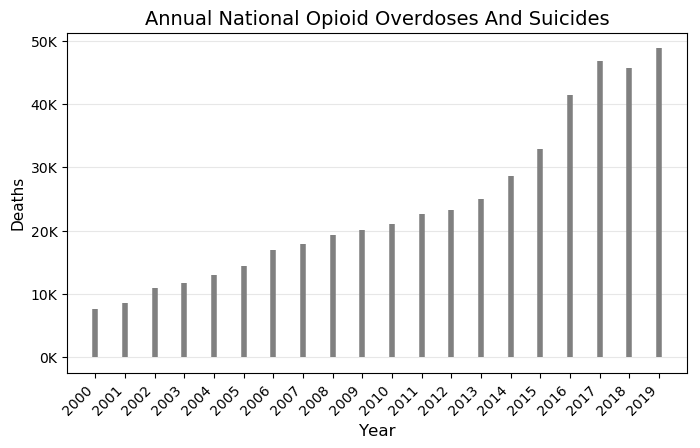

In [8]:
national_overdoses = annual_overdoses.groupby("Year")["Deaths"].sum() + annual_suicides.groupby("Year")["Deaths"].sum()
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
ax.vlines(
    x=national_overdoses.index,
    ymin=0,
    ymax=national_overdoses,
    color="grey",        
    alpha=1.0,
    linewidth=4,
)

ax.set_title(f"Annual National Opioid Overdoses And Suicides", size=14)
plt.grid(axis="y", alpha=0.3)
ax.set_xlabel("Year", size=12)
ax.set_ylabel("Deaths", size=11)
formatter = FuncFormatter(thousands)
ax.yaxis.set_major_formatter(formatter)
fig.autofmt_xdate(rotation=45)

We see above that since 2000 the annual number of unintentional opioid overdoses and suicides has increased by more than a factor five and that since 2010 the annual number of deaths has more than doubled.

### National Opioid Prevalence

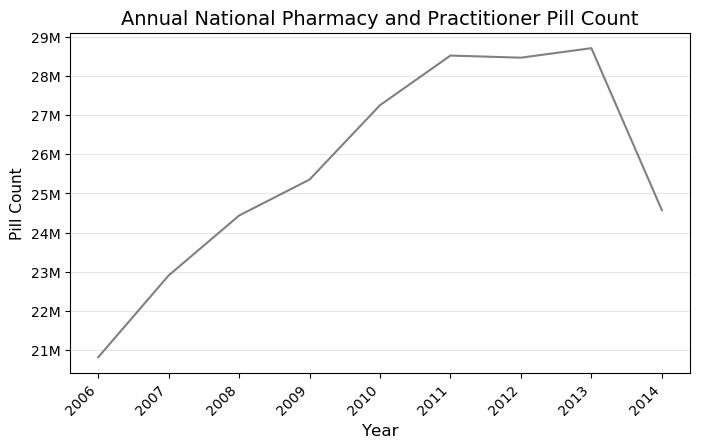

In [9]:
opioids_yearly = arcos_df.groupby('year')['count'].sum()

fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
ax.plot(opioids_yearly, color = 'grey')
ax.set_title(f"Annual National Pharmacy and Practitioner Pill Count", size=14)
plt.grid(axis="y", alpha=0.3)
ax.set_xlabel("Year", size=12)
ax.set_ylabel("Pill Count", size=11)
formatter = FuncFormatter(millions)
ax.yaxis.set_major_formatter(formatter)
fig.autofmt_xdate(rotation=45)

We see above that the number of opioid pills in the United States has increased steadily from 2006 until 2013 when a significant decline occurred in the annual opioid pill count. It should be noted that the count only records pharmacy and practitioner's pill counts and does not include any illicit opioids. The types of opioids included in the count are listed in the arcos_drug_list dataframe shown previously.

### States With The Highest Annual Overdose Rate

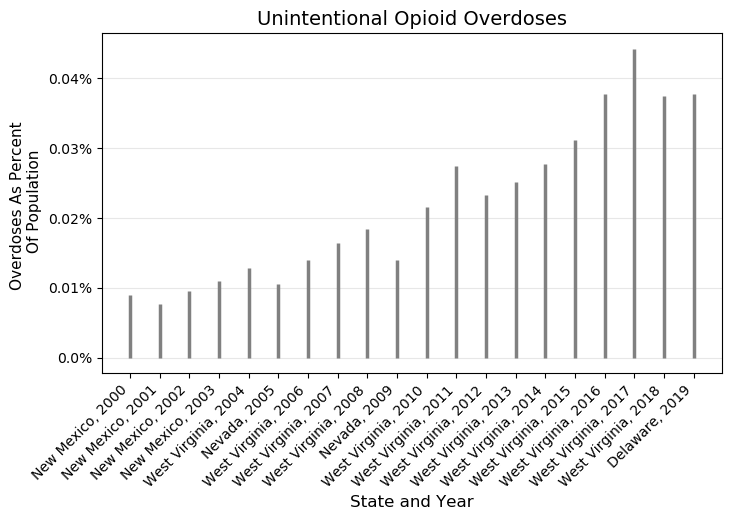

In [10]:
top_states = (
    annual_overdoses.groupby("Year")["State", "% of Population"]
    .apply(lambda grp: grp.nlargest(1, "% of Population"))
    .reset_index()
)
top_states['State_and_Year'] = top_states['State'] + ', ' + top_states['Year']
top_states = top_states.drop(['Year', 'level_1', 'State'], axis = 1)

fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
ax.vlines(
    x=top_states['State_and_Year'],
    ymin=0,
    ymax=top_states['% of Population'],
    color="grey",        
    alpha=1.0,
    linewidth=2.5,
)

ax.set_title(f"Unintentional Opioid Overdoses", size=14)
plt.grid(axis="y", alpha=0.3)
ax.set_xlabel("State and Year", size=12)
ax.set_ylabel("Overdoses As Percent \n Of Population", size=11)
formatter = FuncFormatter(percents)
ax.yaxis.set_major_formatter(formatter)
fig.autofmt_xdate(rotation=45)

In the last twenty years West Virginia has consistently had the highest percentage of unintentional opioid overdose deaths. West Virginia is the leading state in thirteen of the last twenty years including during the time period where there was a significant increase in annual opioid related overdoses and suicides (see figure 1).

Going forward we will take a closer look at West Virginia's statewide opioid overdose and suicide mortality rate and respective changes in anti-epidemic policy.

## 4) Data Cleaning

In [11]:
overdoses_wv = annual_overdoses[annual_overdoses["State"] == "West Virginia"].reset_index(drop=True)
overdoses_wv = overdoses_wv.reset_index()

suicides_wv = annual_suicides[annual_suicides["State"] == "West Virginia"].reset_index(drop=True)
suicides_wv = suicides_wv.reset_index()

monthly_overdoses_wv = monthly_overdoses[monthly_overdoses["State"] == "West Virginia"].reset_index(drop=True)
monthly_overdoses_wv = monthly_overdoses_wv.reset_index()

years  = ['2006', '2007', '2008', '2009', '2010', '2011', '2012',
          '2013', '2014', '2015', '2016', '2017', '2018', '2019']
ticks = []
for year in years:
    index = monthly_overdoses_wv.index[monthly_overdoses_wv['Year'] == year][0]
    ticks.append(index)

For West Virginia we find the number of unintentional opioid overdoses and opioid related suicides.

## 5) Introduction Of Counter Epidemic Laws in West Virginia

In [12]:
display(recmj[recmj['Jurisdictions'] == 'West Virginia'])
display(gsl[gsl['Jurisdictions'] == 'West Virginia'])
display(naloxone[naloxone['Jurisdictions'] == 'West Virginia'])

,Jurisdictions,Effective Date,rec_marijuana
99,West Virginia,2014-10-01,0


,Jurisdictions,Effective Date,goodsam-law
154,West Virginia,2007-01-01,0
155,West Virginia,2015-06-12,1
156,West Virginia,2018-05-09,1


,Jurisdictions,Effective Date,naloxone-access,prescriber-immunity,naloxone-thirdparty
206,West Virginia,2001-01-01,0,0,0
207,West Virginia,2015-05-27,1,0,0
208,West Virginia,2016-06-10,1,0,0


Recreational Marijuana: West Virginia has not introduced any recreational marijuana laws.

Good Samaritan Laws: In 2015, West Virginia introduced legal protections for reporting drug overdoses.

Naloxone Access: In 2015, West Virginia introduced laws permitting prescriptions and access to naloxone.

## 6) West Virginia's Opioid Overdoses and Suicides

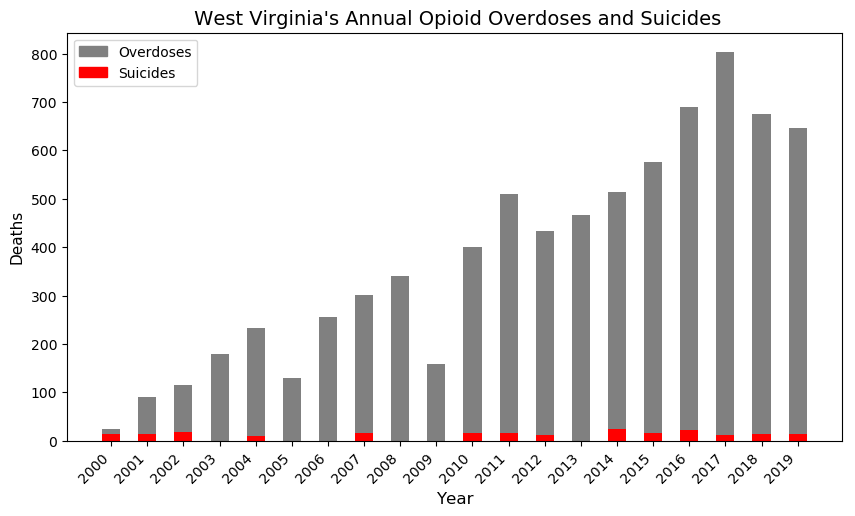

In [13]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

lns1 = ax.bar(overdoses_wv['Year'], overdoses_wv['Deaths'], label='Overdoses', width=0.5, color='grey')
lns2 = ax.bar(suicides_wv['Year'], suicides_wv['Deaths'], label='Overdoses', width=0.5, color='red')

ax.set_title(f" West Virginia's Annual Opioid Overdoses and Suicides", size=14)
ax.set_xlabel("Year", size=12)
ax.set_ylabel("Deaths", size=11)
red_patch = mpatches.Patch(color='red', label='Suicides')
grey_patch = mpatches.Patch(color='grey', label='Overdoses')
plt.legend(handles=[grey_patch, red_patch]) 

fig.autofmt_xdate(rotation=45)
plt.show()

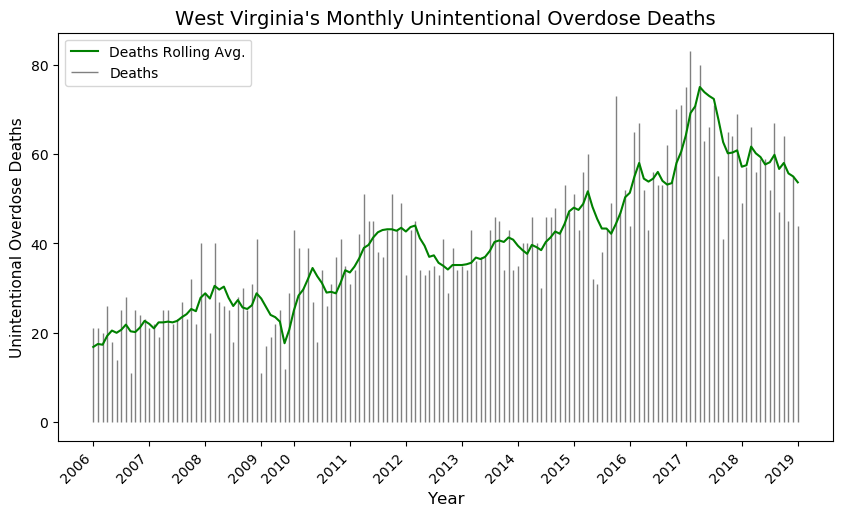

In [14]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
plt.xticks(ticks)
start = monthly_overdoses_wv.index[monthly_overdoses_wv['Year'] == '2006'][0]
end = monthly_overdoses_wv.index[monthly_overdoses_wv['Year'] == '2019'][1]
monthly_overdoses_wv['RollingYrAvg'] = monthly_overdoses_wv['Deaths'].rolling(6).mean() 

lns1 = ax.vlines(
    x=monthly_overdoses_wv.iloc[start:end].index,
    ymin=0,
    ymax=monthly_overdoses_wv['Deaths'].iloc[start:end],
    color="grey",
    alpha=1.0,
    linewidth=1.0,
    label = 'Deaths'
)
lns2 = ax.plot(monthly_overdoses_wv['RollingYrAvg'].iloc[start:end], color = 'green', label = 'Deaths Rolling Avg.')

ax.set_title(f"West Virginia's Monthly Unintentional Overdose Deaths", size=14)
ax.set_xlabel("Year", size=12)
ax.set_xticklabels(years)
ax.set_ylabel("Unintentional Overdose Deaths", size=11)
ax.legend(loc=2)
fig.autofmt_xdate(rotation=45)
plt.show()

Since 2000 the annual number of reported unintentional opioid overdoses has grown from 24 in 2000 to over 600 in 2019 and since 2010 the annual number of unintentional overdoses has nearly doubled. The number of opioid related suicides has remained relatively steady since 2000. Surprisingly, there does not appear to be any decrease to the number of annual opioid overdoses following the 2015 introduction of good samaritan laws and naloxone access laws.

The second image looks at West Virginia's monthly unintentional overdoses with a 6 month rolling average. Here we can see there is not a large level of variation to the number of deaths on a monthly basis but the 6 month rolling average has a clear upward trend.

*The bar graphs for overdoses and suicides are superimposed, not stacked.    
*Some data is missing at a monthly level, particularly prior to 2010.

## 7) Conclusions

In this notebook we first looked at (figure 1) the annual national opioid suicides and unintentional overdoses and in (figure 2) the annual national pharmacy and practitioner opioid pill counts. Next, we found (figure 3) the states each year who have the highest rate of unintentional opioid overdose deaths as a percentage of each state's respective population. Finally, we examined opioid related suicides and unintentional overdoses at the state level in West Virgina (figure 4 and 5) as well as the introduction of West Virginia's counter epidemic laws.